In [1]:
from pathlib import Path
from matplotlib import pyplot as plt

import numpy as np

from jaxpower import Spectrum2Poles, WindowMatrix, BinnedStatistic
from abacus_hf import get_measurement_fn, get_box_measurement_fn

rebin = 5
nmocks = 25
catalog_args = dict(zsnap=0.950, region='NGC', tracer='LRG', zrange=(0.8, 1.1))
imock = 0

from pypower import PowerSpectrumMultipoles, BaseMatrix

def pypower_to_jaxpower(power, remove_direct=False):
    if isinstance(power, PowerSpectrumMultipoles):
        poles = power
        if remove_direct:
            poles = poles.deepcopy()
            poles.power_direct_nonorm[...] = 0.
        num = poles.power * poles.wnorm
        num[poles.ells.index(0)] += poles.shotnoise_nonorm
        return Spectrum2Poles(k=poles.k, num=num, edges=np.column_stack([poles.edges[0][:-1], poles.edges[0][1:]]),
                              ells=poles.ells, nmodes=poles.nmodes, num_shotnoise=poles.shotnoise_nonorm, num_zero=poles.power_zero_nonorm, norm=poles.wnorm)
    if isinstance(power, BaseMatrix):
        wmat = power

        def get_edges(x):
            toret = []
            for xx in x:
                tmp = (xx[:-1] + xx[1:]) / 2.
                tmp = jnp.concatenate([jnp.array([tmp[0] - (xx[1] - xx[0])]), tmp, jnp.array([tmp[-1] + (xx[-1] - xx[-2])])])
                tmp = jnp.column_stack([tmp[:-1], tmp[1:]])
                toret.append(tmp)
            return toret

        edges = get_edges(wmat.xout)
        value = [jnp.zeros(edge.shape[0]) for edge in edges]
        observable = BinnedStatistic(value=value, edges=edges, weights=wmat.weightsout, projs=[proj.ell for proj in wmat.projsout])
        edges = get_edges(wmat.xin)
        value = [jnp.zeros(edge.shape[0]) for edge in edges]
        theory = BinnedStatistic(value=value, edges=edges, weights=wmat.weightsin, projs=[proj.ell for proj in wmat.projsin])
        value = wmat.value.T
        return WindowMatrix(value=value, observable=observable, theory=theory)


In [2]:
pks = [Spectrum2Poles.load(get_measurement_fn(imock=imock, **catalog_args, kind='mesh2spectrum')) for imock in range(nmocks)]
pk_cutsky = Spectrum2Poles.mean(pks).slice(slice(0, None, rebin))
cov_cutsky = Spectrum2Poles.cov(pks).slice(slice(0, None, rebin))
cov_cutsky = cov_cutsky.clone(value=np.diag(np.diag(cov_cutsky.view())))
wmat_cutsky = WindowMatrix.load(get_measurement_fn(imock=0, **catalog_args, kind='window_mesh2spectrum'))
wmat_cutsky = wmat_cutsky.slice(slice(0, None, rebin), axis='o')
pk_box = Spectrum2Poles.mean([Spectrum2Poles.load(get_box_measurement_fn(imock=imock, **catalog_args, kind='mesh2spectrum')) for imock in range(nmocks)])
pk_box = pk_box.slice(slice(0, None, rebin))

In [3]:
wmat_box = WindowMatrix.load(get_box_measurement_fn(imock=0, **catalog_args, kind='window_mesh2spectrum'))

wmat_square = wmat_box.slice(slice(0, None, 5), axis='o').slice(slice(0, None, 5), axis='t')
# Invert the square window matrix
observable_to_theory = wmat_square.clone(value=np.linalg.inv(wmat_square.view()),
                                         theory=wmat_square.observable, observable=wmat_square.theory)

pk_box_deconvolved = observable_to_theory.dot(pk_box, return_type=None)

# Let's just do a spline interpolation of the "deconvolved" P(k)
# (one could do something better, fitting some real model given a preliminary covariance matrix)

from jax import numpy as jnp
from scipy import interpolate

def pk_theory_callable(k):
    # Insert 0 to enforce P(k=0) = 0
    x = jnp.insert(pk_box_deconvolved.x(0), 0, 0.)
    y = jnp.stack([jnp.insert(pk_box_deconvolved.view(projs=proj), 0, 0.) for proj in pk_box_deconvolved.projs])
    return interpolate.interp1d(x, y, kind='cubic', axis=-1, bounds_error=False, fill_value=0., assume_sorted=True)(k)

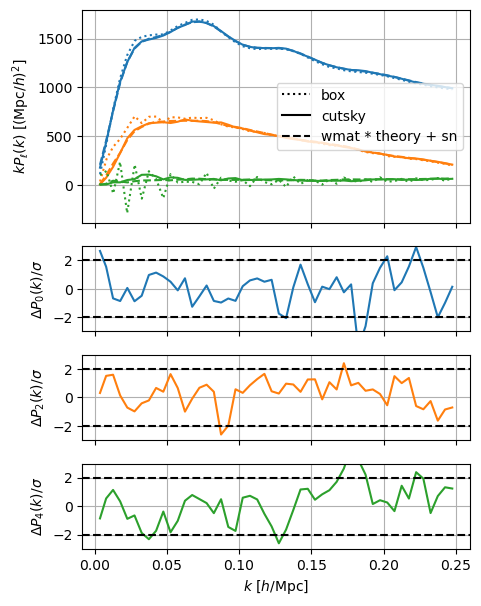

In [4]:
def plot_validation(pk_box, pk_cutsky, pk_theory_callable, wmat, cov_cutsky, klim=(0., 0.25), marg_shotnoise=False):
    wmat = wmat.select(xlim=klim, axis='o')
    kin = wmat.theory.x(projs=0)
    pk_theory = wmat.theory.clone(value=list(pk_theory_callable(kin)))
    pk_box, pk_cutsky, cov_cutsky = (pk.select(xlim=klim) for pk in [pk_box, pk_cutsky, cov_cutsky])
    ells = pk_cutsky.projs
    pk_std = [np.diag(cov_cutsky.select(projs=ell, select_projs=True))**0.5 / nmocks**0.5 for ell in ells]
    pk_wmat = wmat.dot(pk_theory.view(), return_type=None)
    if marg_shotnoise:
        pk_shotnoise = pk_theory.clone(value=[(ell == 0) * np.ones_like(pk_theory.view(projs=ell)) for ell in pk_theory.projs])
        diff = pk_wmat.view().real - pk_cutsky.view().real
        cov = cov_cutsky.view()
        grad = wmat.dot(pk_shotnoise)
        ph = np.linalg.solve(cov, grad)
        sn = 1. / grad.T.dot(ph) * ph.dot(diff)
        pk_wmat = wmat.dot(pk_theory.view() - sn * pk_shotnoise.view(), return_type=None)

    fig, lax = plt.subplots(1 + len(ells), figsize=(5, 7), sharey=False, sharex=True,
                gridspec_kw={'height_ratios': [2.5] + [1] * len(ells)}, squeeze=True)
    ax = lax[0]
    ax.plot([], [], color='k', linestyle=':', label='box')
    ax.plot([], [], color='k', linestyle='-', label='cutsky')
    ax.plot([], [], color='k', linestyle='--', label='wmat * theory + sn' if marg_shotnoise else 'wmat * theory')
    
    for ill, ell in enumerate(ells):
        color = 'C{:d}'.format(ill)
        k = pk_box.x(projs=ell)
        ax.plot(k, k * pk_box.view(projs=ell).real, color=color, linestyle=':')
        k = pk_cutsky.x(projs=ell)
        ax.plot(k, k * pk_cutsky.view(projs=ell).real, color=color, linestyle='-')
        ax.plot(k, k * pk_wmat.view(projs=ell).real, color=color, linestyle='--')
        diff = (pk_wmat.view(projs=ell).real - pk_cutsky.view(projs=ell).real) / (pk_std[ill])
        lax[1 + ill].plot(k, diff, color=color, linestyle='-')
        lax[1 + ill].set_ylim(-3., 3.)
        for y in [-2., 2.]: lax[1 + ill].axhline(y, color='k', linestyle='--')
        lax[1 + ill].set_ylabel(rf'$\Delta P_{ell:d}(k) / \sigma$')

    lax[-1].set_xlabel(r'$k$ [$h/\mathrm{Mpc}$]')
    lax[0].set_ylabel(r'$k P_{\ell}(k)$ [$(\mathrm{Mpc}/h)^{2}$]')
    lax[0].legend()
    for ax in lax: ax.grid(True)
    plt.show()

plot_validation(pk_box, pk_cutsky, pk_theory_callable, wmat_cutsky, cov_cutsky, marg_shotnoise=True)

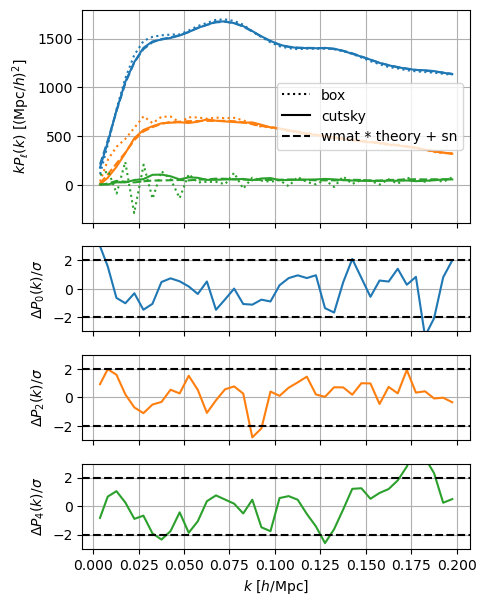

In [5]:
pypower_wmat_cutsky = pypower_to_jaxpower(BaseMatrix.load(get_measurement_fn(imock=0, **catalog_args, kind='window_pypower')))
pypower_wmat_cutsky = pypower_wmat_cutsky.slice(slice(0, None, rebin), axis='o')

def rebin_wmat_theory(wmat, new):

    def matrix_lininterp(xin, xout):
        # Matrix for linear interpolation
        toret = np.zeros((len(xin), len(xout)), dtype='f8')
        for iout, xout in enumerate(xout):
            iin = np.searchsorted(xin, xout, side='right') - 1
            if 0 <= iin < len(xin) - 1:
                frac = (xout - xin[iin]) / (xin[iin + 1] - xin[iin])
                toret[iin, iout] = 1. - frac
                toret[iin + 1, iout] = frac
            elif np.isclose(xout, xin[-1]):
                toret[iin, iout] = 1.
        return toret

    from scipy import linalg
    rebin = linalg.block_diag(*[matrix_lininterp(new, old) for old, new in zip(wmat.theory.x(), new.x())])
    return wmat.clone(theory=new, value=wmat.view().dot(rebin.T))  # rebinned window matrix

pypower_wmat_cutsky = rebin_wmat_theory(pypower_wmat_cutsky, wmat_cutsky.theory)

plot_validation(pk_box, pk_cutsky, pk_theory_callable, pypower_wmat_cutsky, cov_cutsky,
                klim=(0., 0.2), marg_shotnoise=True)

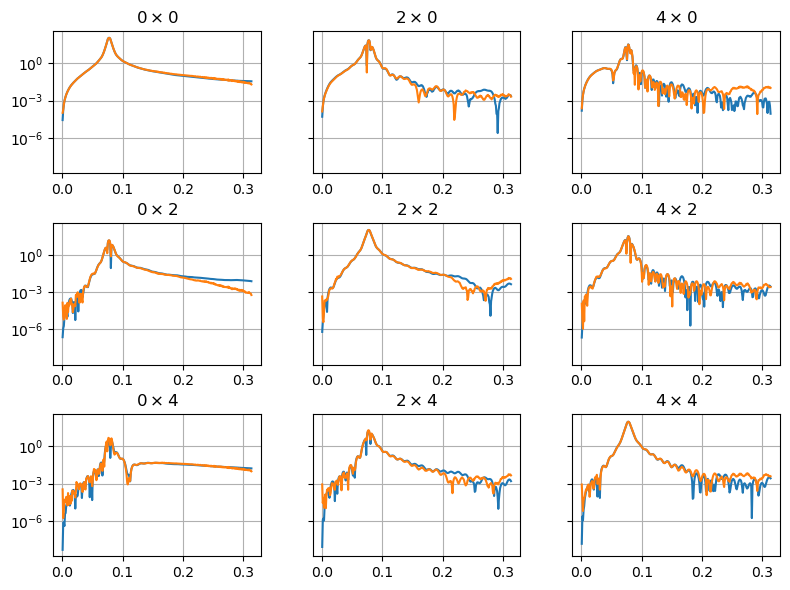

In [6]:
index = 15
fig = wmat_cutsky.plot_slice(index, show=False);
pypower_wmat_cutsky.plot_slice(index, fig=fig, color='C1', show=True);

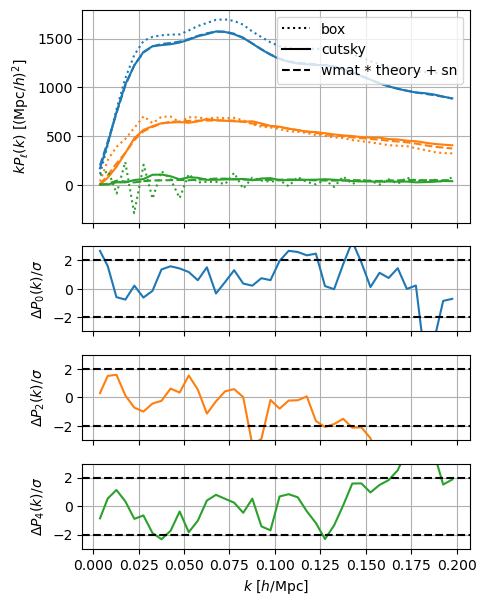

In [7]:
pks = [Spectrum2Poles.load(get_measurement_fn(imock=imock, **catalog_args, kind='mesh2spectrum_thetacut')) for imock in range(nmocks)]
pk_cutsky_thetacut = Spectrum2Poles.mean(pks).slice(slice(0, None, rebin))
cov_cutsky_thetacut = Spectrum2Poles.cov(pks).slice(slice(0, None, rebin))
cov_cutsky_thetacut = cov_cutsky_thetacut.clone(value=np.diag(np.diag(cov_cutsky_thetacut.view())))
wmat_cutsky_thetacut = WindowMatrix.load(get_measurement_fn(imock=0, **catalog_args, kind='window_mesh2spectrum_thetacut'))
wmat_cutsky_thetacut = wmat_cutsky_thetacut.slice(slice(0, None, rebin), axis='o')

plot_validation(pk_box, pk_cutsky_thetacut, pk_theory_callable, wmat_cutsky_thetacut, cov_cutsky_thetacut,
                klim=(0., 0.2), marg_shotnoise=True)

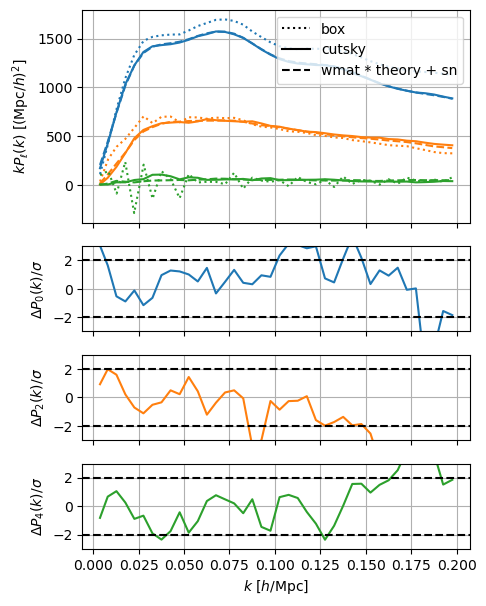

In [8]:
pypower_wmat_cutsky_thetacut = pypower_to_jaxpower(BaseMatrix.load(get_measurement_fn(imock=0, **catalog_args, kind='window_pypower_thetacut')))
pypower_wmat_cutsky_thetacut = pypower_wmat_cutsky_thetacut.slice(slice(0, None, rebin), axis='o')
pypower_wmat_cutsky_thetacut = rebin_wmat_theory(pypower_wmat_cutsky_thetacut, wmat_cutsky_thetacut.theory)

plot_validation(pk_box, pk_cutsky_thetacut, pk_theory_callable, pypower_wmat_cutsky_thetacut, cov_cutsky_thetacut,
                klim=(0., 0.2), marg_shotnoise=True)

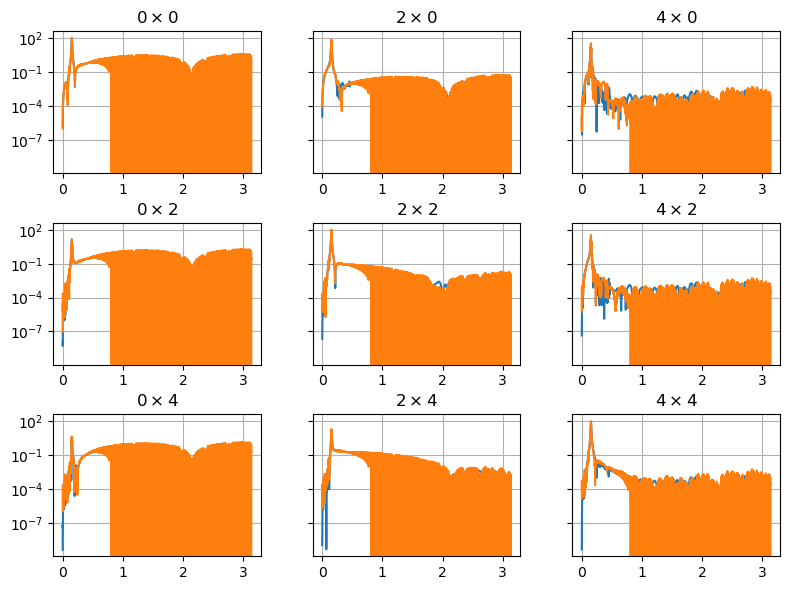

In [9]:
index = 30
fig = wmat_cutsky_thetacut.plot_slice(index, show=False);
pypower_wmat_cutsky_thetacut.plot_slice(index, fig=fig, color='C1', show=True);

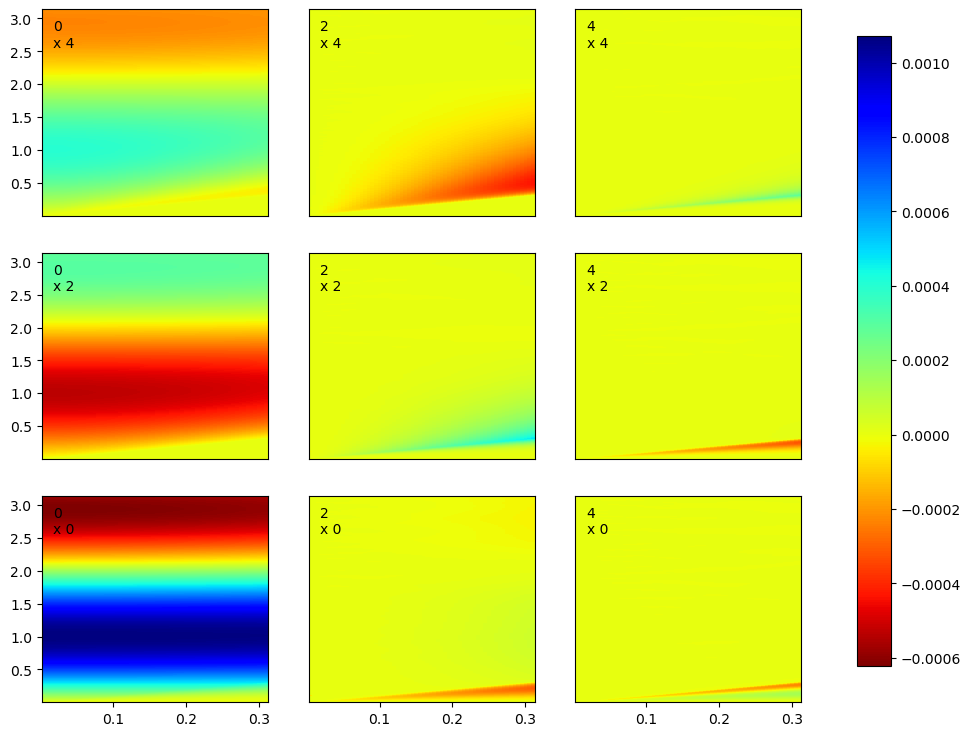

In [10]:
edgesin = wmat_cutsky.theory.edges(projs=0)
edgesin = jnp.arange(edgesin.min(), 10. * edgesin.max(), edgesin[0, 1] - edgesin[0, 0])
edgesin = jnp.column_stack([edgesin[:-1], edgesin[1:]])
theory = BinnedStatistic(edges=[edgesin] * len(wmat_cutsky.theory.projs),
                         value=[jnp.zeros_like(edgesin[:, 0])] * len(wmat_cutsky.theory.projs),
                         projs=wmat_cutsky.theory.projs)
wmat_cutsky_extended = WindowMatrix.load(get_measurement_fn(imock=0, **catalog_args, kind='window_mesh2spectrum')).interp(theory, axis='t', extrap=True)
wmat_cutsky_extended = wmat_cutsky_extended.slice(slice(0, None, 5))
wmat_diff = wmat_cutsky_extended.clone(value=wmat_cutsky_extended.view() - wmat_cutsky_thetacut.view())
wmat_diff.plot(show=True);

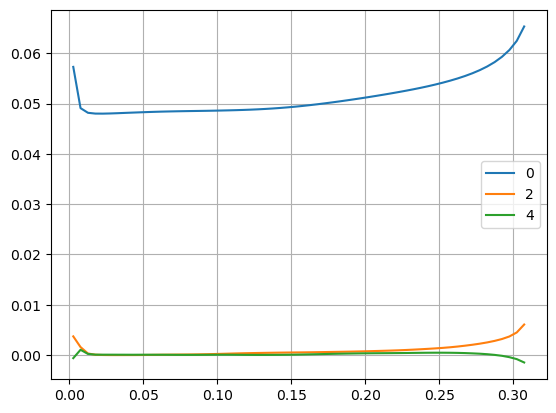

In [17]:
shotnoise = jnp.concatenate([jnp.ones_like(wmat_cutsky_thetacut.theory.x(ell)) * (ell == 0) for ell in wmat_cutsky_thetacut.theory.projs])
shotnoise = wmat_cutsky_thetacut.dot(shotnoise, return_type=None)

shotnoise.plot(show=True);

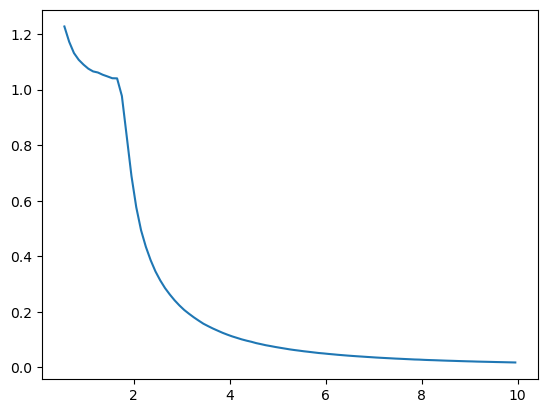

In [12]:
imock = 0
from jaxpower import Correlation2Poles
cut = Correlation2Poles.load(get_measurement_fn(imock=imock, **catalog_args, kind='window_xi_thetacut'))

cut = cut.select(xlim=(0.5, 10.))
ax = plt.gca()
ell = 0
volume = 4. / 3. * jnp.pi * jnp.diff(cut.edges(0)**3, axis=-1).ravel()
ax.plot(cut.x(projs=ell), cut.view(projs=ell) / volume)
plt.show()

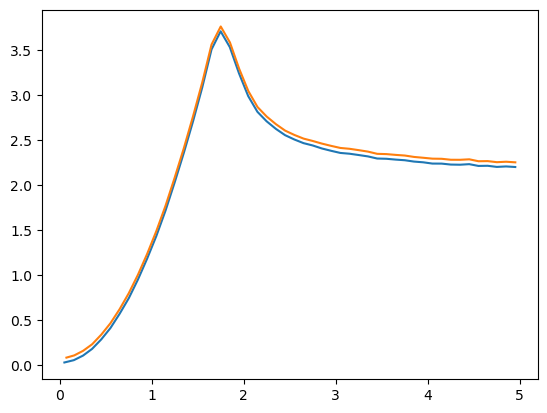

In [13]:
imock = 0
from pypower import CatalogSmoothWindow
cut = Correlation2Poles.load(get_measurement_fn(imock=imock, **catalog_args, kind='window_xi_thetacut'))
pypower_cut = CatalogSmoothWindow.load(get_measurement_fn(imock=imock, **catalog_args, kind='window_pypower_xi0'))

ax = plt.gca()
ell = 0
xlim = (0, 5)
mask = pypower_cut.sep_direct < xlim[1]
# 0.05476021727502001
ax.plot(pypower_cut.sep_direct[mask], -pypower_cut.corr_direct_nonorm[0][mask] / pypower_cut.wnorm[0])
mask = cut.x(projs=ell) < xlim[1]
ax.plot(cut.x(projs=ell)[mask], cut.view(projs=ell)[mask])
plt.show()

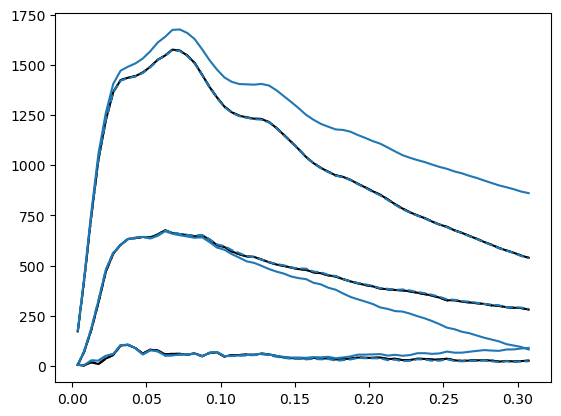

In [14]:
pks = [pypower_to_jaxpower(PowerSpectrumMultipoles.load(get_measurement_fn(imock=imock, **catalog_args, kind='pypower', remove_direct=True))) for imock in range(nmocks)]
pypower_cutsky = Spectrum2Poles.mean(pks).slice(slice(0, None, rebin))

pks = [pypower_to_jaxpower(PowerSpectrumMultipoles.load(get_measurement_fn(imock=imock, **catalog_args, kind='pypower'))) for imock in range(nmocks)]
pypower_cutsky_thetacut = Spectrum2Poles.mean(pks).slice(slice(0, None, rebin))

ax = plt.gca()
for ill, ell in enumerate(pk_cutsky.projs):
    k = pk_cutsky.x(projs=ell)
    ax.plot(k, k * pypower_cutsky_thetacut.view(projs=ell), color='k', linestyle='--')
    ax.plot(k, k * pypower_cutsky.view(projs=ell), color='k', linestyle='-')
    color = 'C0'
    ax.plot(k, k * pk_cutsky_thetacut.view(projs=ell), color=color, linestyle='--')
    ax.plot(k, k * pk_cutsky.view(projs=ell), color=color, linestyle='-')
plt.show()

/global/cfs/projectdirs/desi/mocks/cai/abacus_HF/DR2_v1.0/desipipe_test/AbacusSummit_base_c000_ph000/CutSky/LRG/thetacut_abacusHF_DR2_LRG_z0p950_z0.8-1.1_NGC.npy


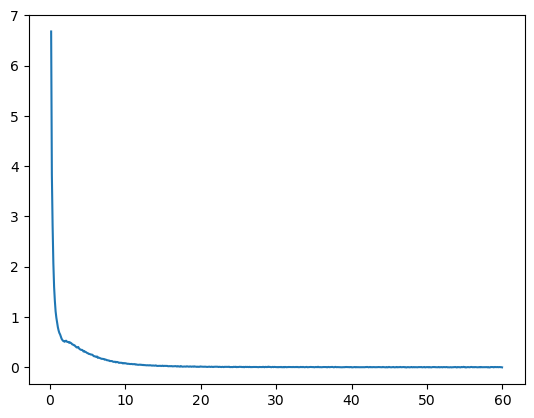

In [15]:
print(get_measurement_fn(imock=imock, **catalog_args, kind='thetacut'))
cut = Spectrum2Poles.load(get_measurement_fn(imock=imock, **catalog_args, kind='thetacut'))
#cut = cut.clone(num_shotnoise=0.)
pypower = PowerSpectrumMultipoles.load(get_measurement_fn(imock=imock, **catalog_args, kind='pypower'))
pypower = pypower.attrs['corr_direct_R1R2']['corr_nonorm']

ax = plt.gca()
for ill, ell in enumerate(cut.projs[:1]):
    color = 'C{:d}'.format(ill)
    x = cut.x(projs=ell)
    mask = (x >= 0.1) & (x < 60.)
    ref = pypower[ill][mask]
    ax.plot(x[mask], cut.view(projs=ell)[mask] / ref, color=color, linestyle='-')
    #ax.plot(x[mask], ref, color=color, linestyle='--')
plt.show() 